In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from prophet import Prophet

In [7]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [8]:
def mean_absolute_error_percentage(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
pjme=pd.read_csv("/content/sample_data/mock_kaggle.csv", index_col=[0],parse_dates=[0])
pjme.head()

,venda,estoque,preco
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


In [10]:
pjme.rename(columns={"venda":"sales","estoque":"stock","preco":"price"},inplace=True)
pjme.head()

,sales,stock,price
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


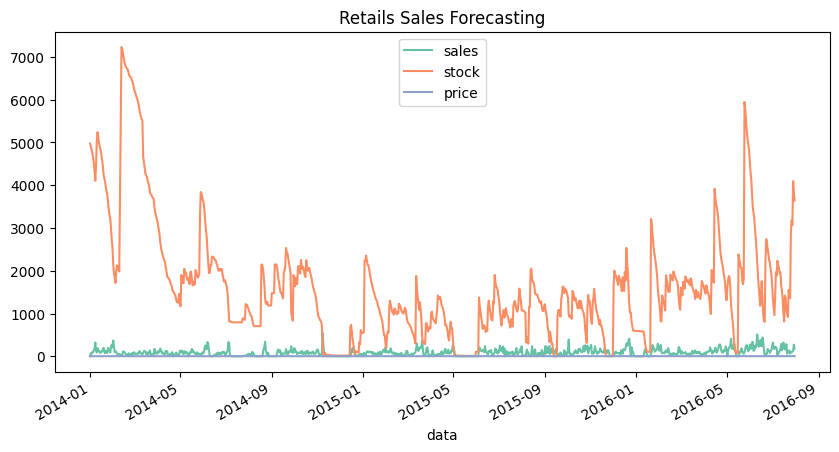

In [11]:
color_palette = sns.color_palette("Set2", 10)
pjme.plot(figsize=(10, 5), ms=1, color=color_palette, title="Retails Sales Forecasting")
plt.show()

**Time series Features**

In [12]:
from pandas.api.types import CategoricalDtype
cat_type=CategoricalDtype(categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True)
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df=df.copy()
    df['date'] = df.index
    df['hour']=df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday']=df['date'].dt.day_name()
    df['weekday']=df['weekday'].astype(cat_type)
    df['quarter']=df['date'].dt.quarter
    df['month']=df['date'].dt.month
    df['year']=df['date'].dt.year
    df['dayofyear']=df['date'].dt.dayofyear
    df['dayofmonth']=df['date'].dt.day
    df['weekofyear']=df['date'].dt.isocalendar().week
    df['date_offset']=(df.date.dt.month*100+df.date.dt.day-320)%1300

    df['season']=pd.cut(df['date_offset'],bins=[0,300,600,900,1300],labels=['Winter','Spring','Summer','Fall'])

    X=df[['hour','dayofweek','weekday','quarter','month','year','dayofyear','dayofmonth','weekofyear','season']]
    if label:
        y=df[label]
        return X,y
    return X
X,y=create_features(pjme,label='sales')
feature_and_target=pd.concat([X,y],axis=1)

feature_and_target.head()

,hour,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,sales
data,,,,,,,,,,,
2014-01-01,0,2,Wednesday,1,1,2014,1,1,1,Fall,0
2014-01-02,0,3,Thursday,1,1,2014,2,2,1,Fall,70
2014-01-03,0,4,Friday,1,1,2014,3,3,1,Fall,59
2014-01-04,0,5,Saturday,1,1,2014,4,4,1,Fall,93
2014-01-05,0,6,Sunday,1,1,2014,5,5,1,Fall,96


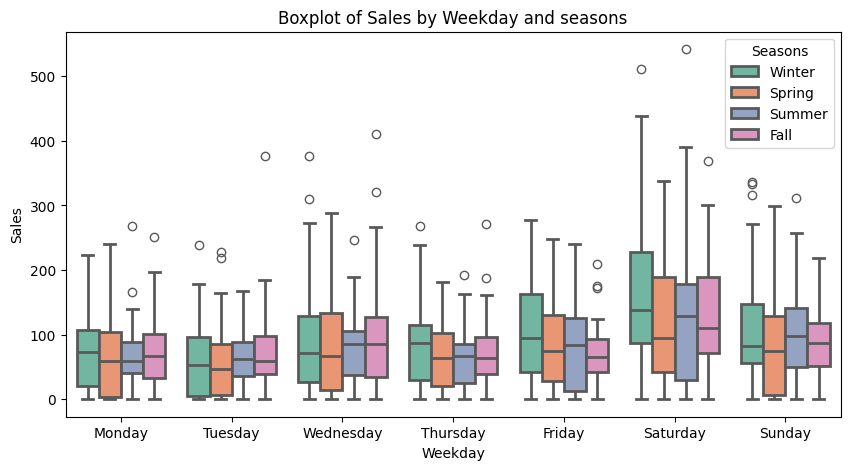

In [13]:
fig, ax=plt.subplots(figsize=(10,5))
sns.boxplot(x='weekday',y='sales',data=feature_and_target.dropna(),ax=ax,
            hue='season',palette='Set2', linewidth=2)
ax.set_title('Boxplot of Sales by Weekday and seasons')
ax.set_xlabel('Weekday')
ax.set_ylabel('Sales')
ax.legend(title='Seasons')
plt.show()

**Train and Test split**

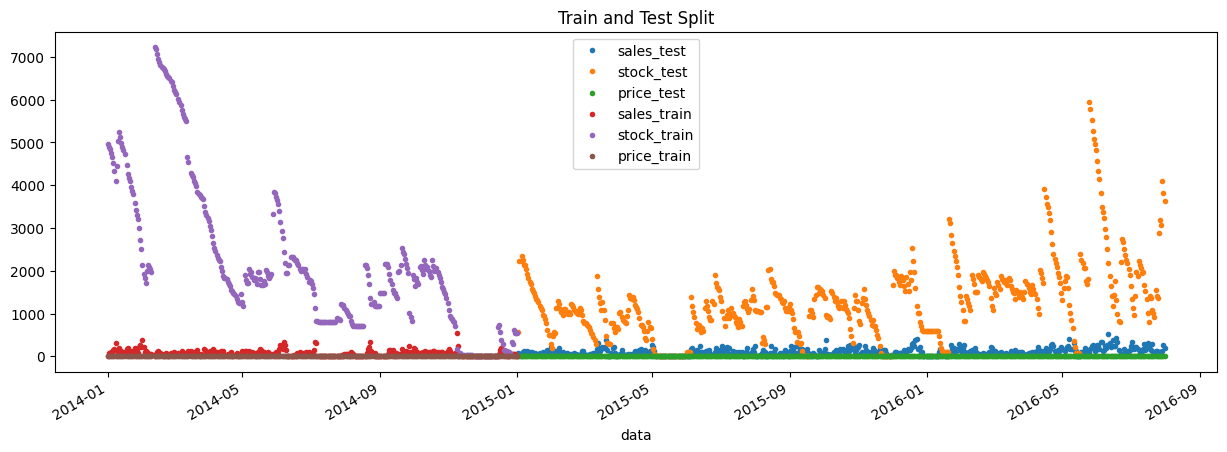

In [14]:
split_date='1-jan-2015'
pjme_train=pjme.loc[pjme.index<=split_date].copy()
pjme_test=pjme.loc[pjme.index>split_date].copy()
#plot train and test to see where we have the split
pjme_test\
  .rename(columns={'sales':'sales_test'})\
  .join(pjme_train.rename(columns={'sales':'sales_train'}),
        how='outer',lsuffix='_test', rsuffix='_train')\
  .plot(figsize=(15,5),title='Train and Test Split',style=('.'))
plt.show()

**let's make a prophet model for our forecasts**

In [15]:
pjme_train_prophet=pjme_train.reset_index()\
.rename(columns={'data':'ds','sales':'y'})
pjme_train_prophet.head()

,ds,y,stock,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [16]:
%%time
model=Prophet()
model.fit(pjme_train_prophet)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoo9xe1es/pklcczi4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoo9xe1es/os2ym3wh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82981', 'data', 'file=/tmp/tmpoo9xe1es/pklcczi4.json', 'init=/tmp/tmpoo9xe1es/os2ym3wh.json', 'output', 'file=/tmp/tmpoo9xe1es/prophet_modeloyrc4gov/prophet_model-20251007090355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 43.8 ms, sys: 530 µs, total: 44.3 ms
Wall time: 113 ms


In [17]:
# Prepare the test data for Prophet
pjme_test_prophet = pjme_test.reset_index()\
    .rename(columns={'data': 'ds', 'sales': 'y'})
pjme_test_prophet.head()

,ds,y,stock,price
0,2015-01-02,77,561,1.29
1,2015-01-03,60,2229,1.29
2,2015-01-04,1,2228,1.29
3,2015-01-05,69,2351,1.29
4,2015-01-06,98,2253,1.29


In [18]:
%%time
model=Prophet()
model.fit(pjme_test_prophet)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoo9xe1es/vg7rizwn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoo9xe1es/ssaknfdk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54515', 'data', 'file=/tmp/tmpoo9xe1es/vg7rizwn.json', 'init=/tmp/tmpoo9xe1es/ssaknfdk.json', 'output', 'file=/tmp/tmpoo9xe1es/prophet_modeldmcw4cln/prophet_model-20251007090355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 35.8 ms, sys: 4.89 ms, total: 40.7 ms
Wall time: 71 ms


In [19]:
#making predictions using test set with the model
pjme_test_predictions=model.predict(pjme_test_prophet)
pjme_test_predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,66.033664,-30.848986,153.609646,66.033664,66.033664,-0.355175,-0.355175,-0.355175,-0.355175,-0.355175,-0.355175,0.0,0.0,0.0,65.678489
1,2015-01-03,66.137831,24.813647,208.039815,66.137831,66.137831,55.004283,55.004283,55.004283,55.004283,55.004283,55.004283,0.0,0.0,0.0,121.142114
2,2015-01-04,66.241998,-24.310563,162.572056,66.241998,66.241998,3.801664,3.801664,3.801664,3.801664,3.801664,3.801664,0.0,0.0,0.0,70.043662
3,2015-01-05,66.346165,-52.298523,133.550581,66.346165,66.346165,-22.992099,-22.992099,-22.992099,-22.992099,-22.992099,-22.992099,0.0,0.0,0.0,43.354066
4,2015-01-06,66.450332,-51.077381,136.140049,66.450332,66.450332,-23.525303,-23.525303,-23.525303,-23.525303,-23.525303,-23.525303,0.0,0.0,0.0,42.925030


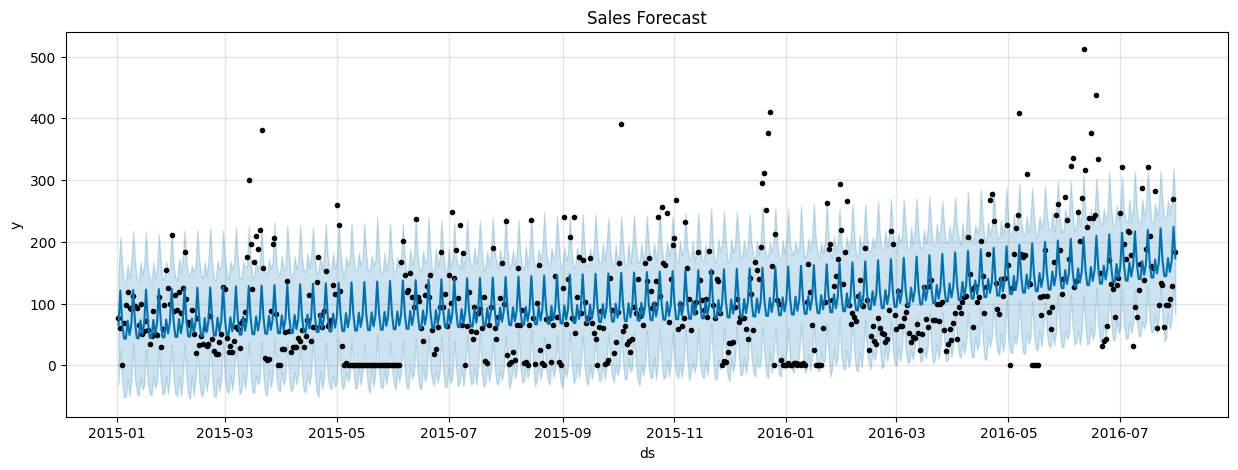

In [20]:
fig, ax=plt.subplots(figsize=(15,5))
model.plot(pjme_test_predictions,ax=ax)
ax.set_title('Sales Forecast')
plt.show()

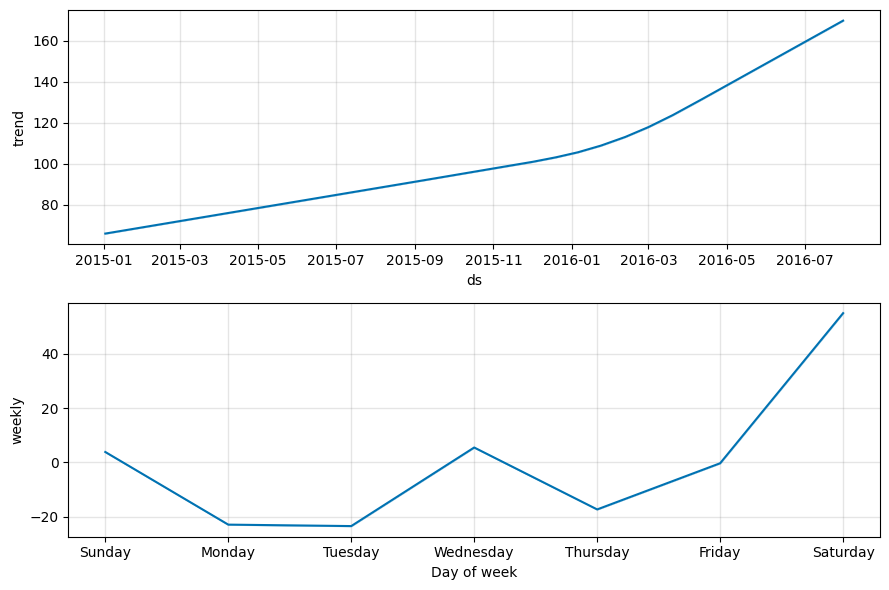

In [21]:
fig=model.plot_components(pjme_test_predictions)
plt.show()

**let's compare Forecast to Actuals**

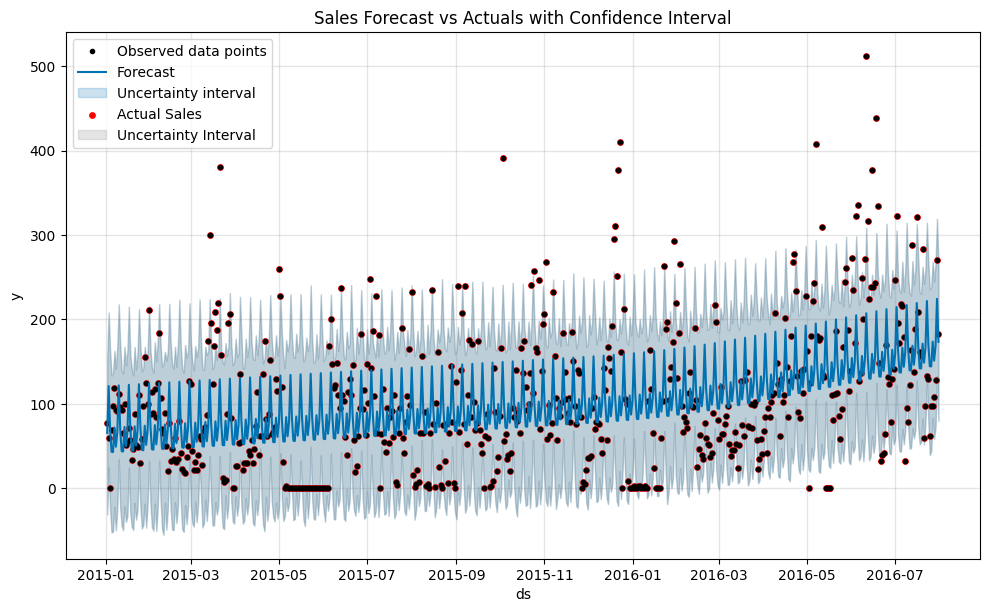

In [22]:
fig = model.plot(pjme_test_predictions)
ax = fig.gca()
ax.scatter(pjme_test.index, pjme_test["sales"], color="red", label="Actual Sales", s=15)
ax.fill_between(pjme_test_predictions["ds"],
                pjme_test_predictions["yhat_lower"],
                pjme_test_predictions["yhat_upper"],
                color="gray", alpha=0.2, label="Uncertainty Interval")
ax.set_title("Sales Forecast vs Actuals with Confidence Interval")
ax.legend()
plt.show()

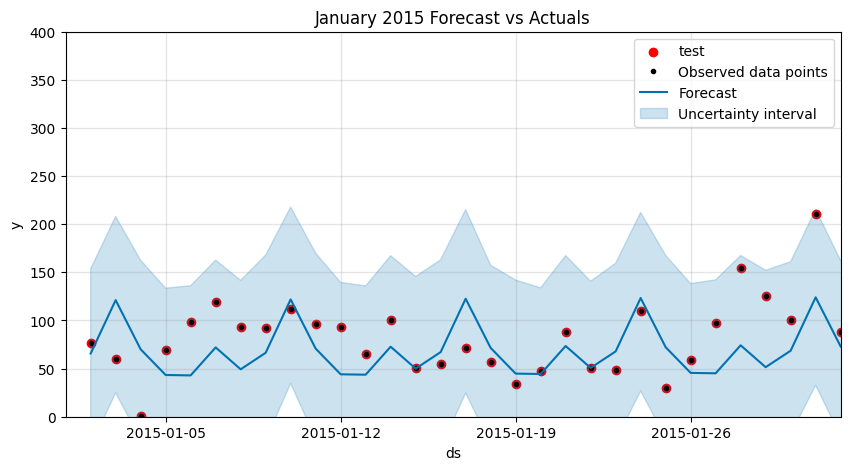

In [23]:
fig, ax=plt.subplots(figsize=(10,5))
ax.scatter(pjme_test.index, pjme_test['sales'], label='test', color='r')
fig=model.plot(pjme_test_predictions,ax=ax)

ax.set_xbound(lower=pd.to_datetime('01-01-2015'), upper=pd.to_datetime('02-01-2015'))
ax.set_title('January 2015 Forecast vs Actuals')
ax.set_ylim(0,400)
ax.legend()
plt.show()

**Let's Evaluate the model with Error Metrics**

In [24]:
np.sqrt(mean_squared_error(pjme_test['sales'],pjme_test_predictions['yhat']))

np.float64(73.83518592472028)

In [25]:
mean_absolute_error(y_true=pjme_test['sales'],y_pred=pjme_test_predictions['yhat'])*100

5637.569271298749

**Predicting into the future**

In [26]:
future=model.make_future_dataframe(periods=365*24,freq='h', include_history=False)
forecast=model.predict(future)


In [27]:
forecast[['yhat']].head()

,yhat
0,171.170615
1,168.976105
2,166.896242
3,164.935570
4,163.097086


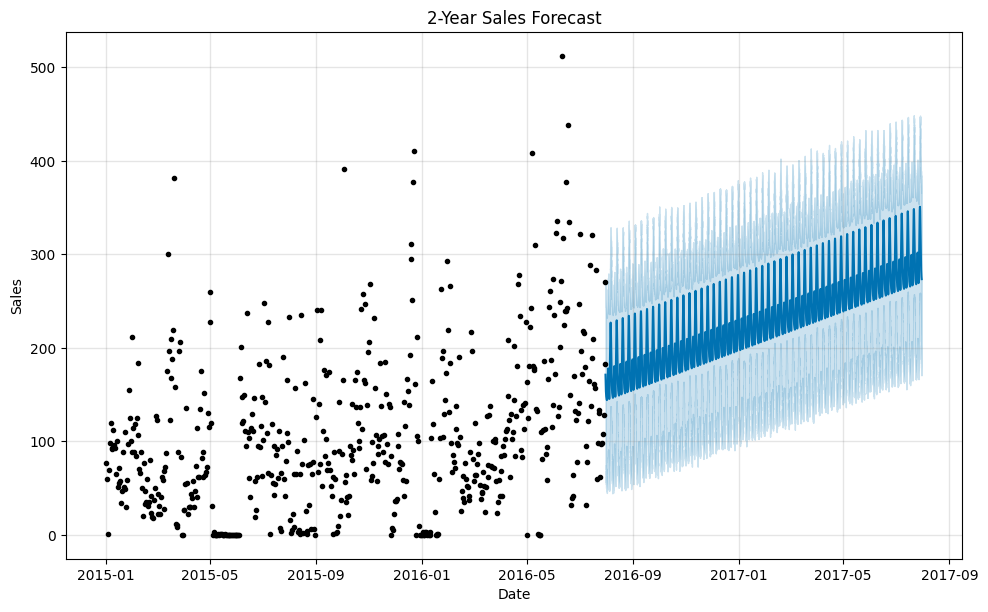

In [28]:

#Plot the forecast

fig1 = model.plot(forecast)
plt.title("2-Year Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

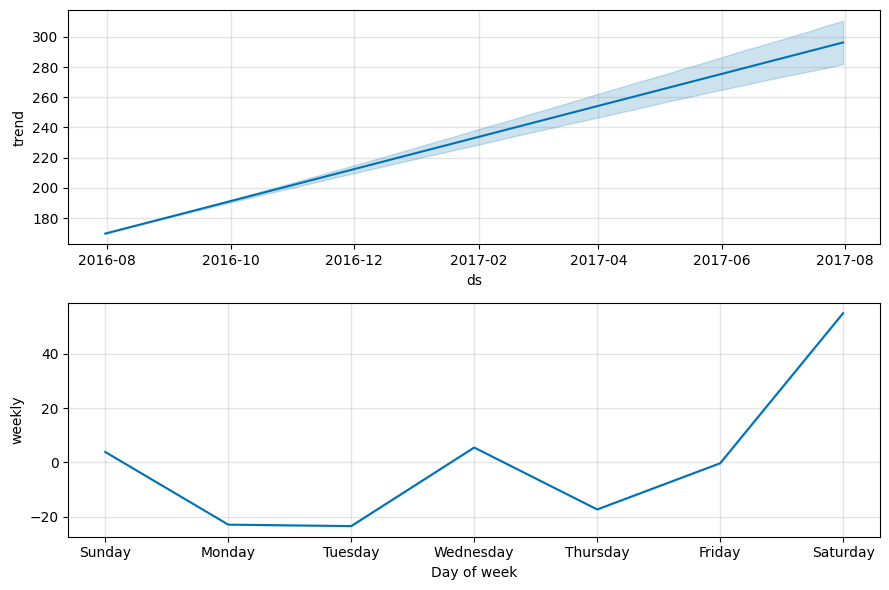

In [37]:
#Plot forecast components (trend, weekly, yearly seasonality) ---
fig2 = model.plot_components(forecast)
plt.show()


**Sales Forecast: Actuals vs prophet Forecast**

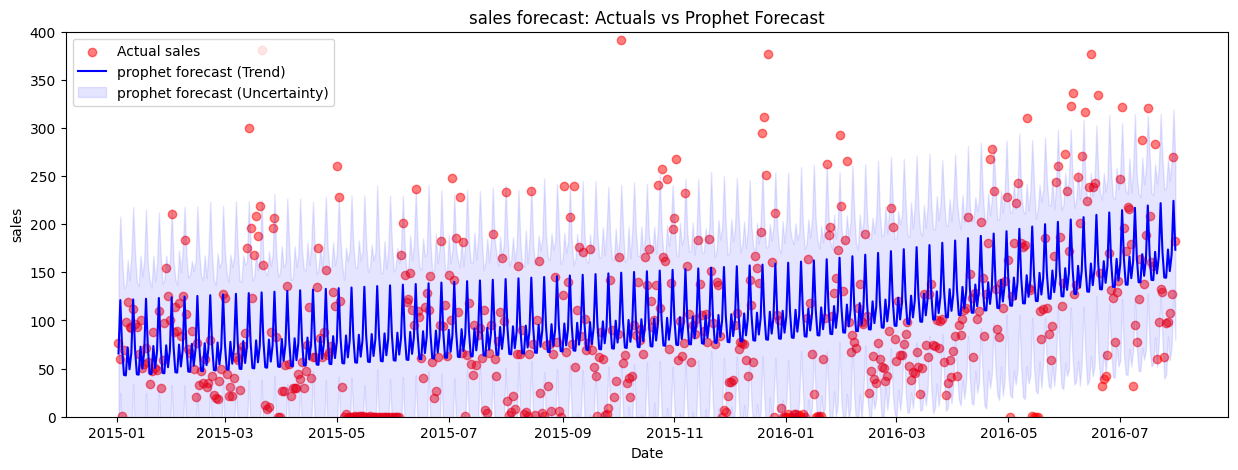

In [29]:
fig, ax=plt.subplots(figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test['sales'], label='Actual sales', color='r', alpha=0.5)
ax.plot(pjme_test_predictions['ds'],pjme_test_predictions['yhat'], label='prophet forecast (Trend)', color='b')
ax.fill_between(pjme_test_predictions['ds'],pjme_test_predictions['yhat_lower'],pjme_test_predictions['yhat_upper'], color='b', alpha=0.1, label='prophet forecast (Uncertainty)')
ax.set_title('sales forecast: Actuals vs Prophet Forecast')
ax.set_xlabel('Date')
ax.set_ylim(0,400)
ax.set_ylabel('sales')
ax.legend()
plt.show()

**Monthly and yearly sales comparison**

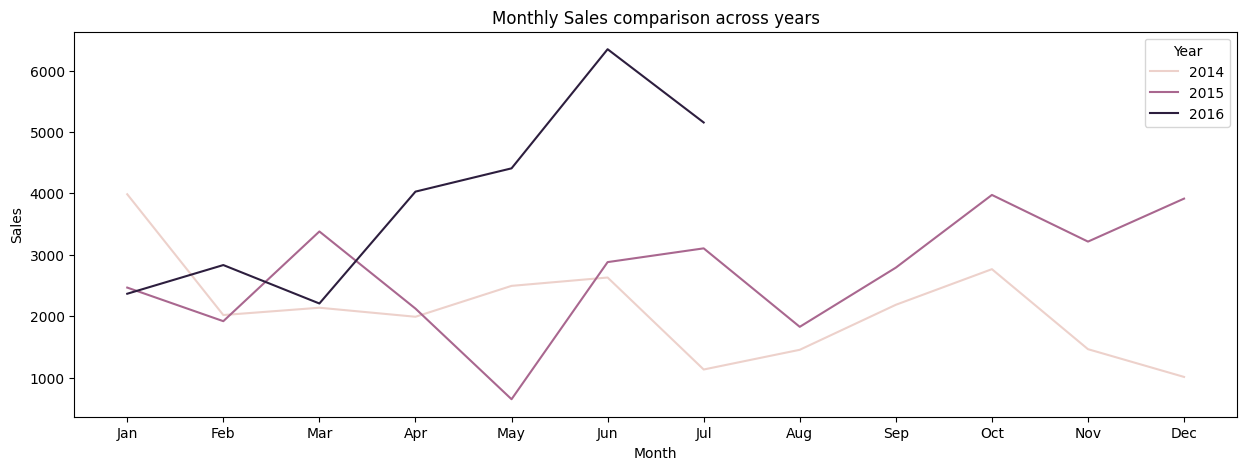

In [30]:
#lets visualize actual monthly sales
monthly_sales=feature_and_target.groupby(['year','month'])['sales'].sum().reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(x='month',y='sales',hue='year',data=monthly_sales, color=sns.set_palette)
plt.title('Monthly Sales comparison across years')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(range(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Year')
plt.show()

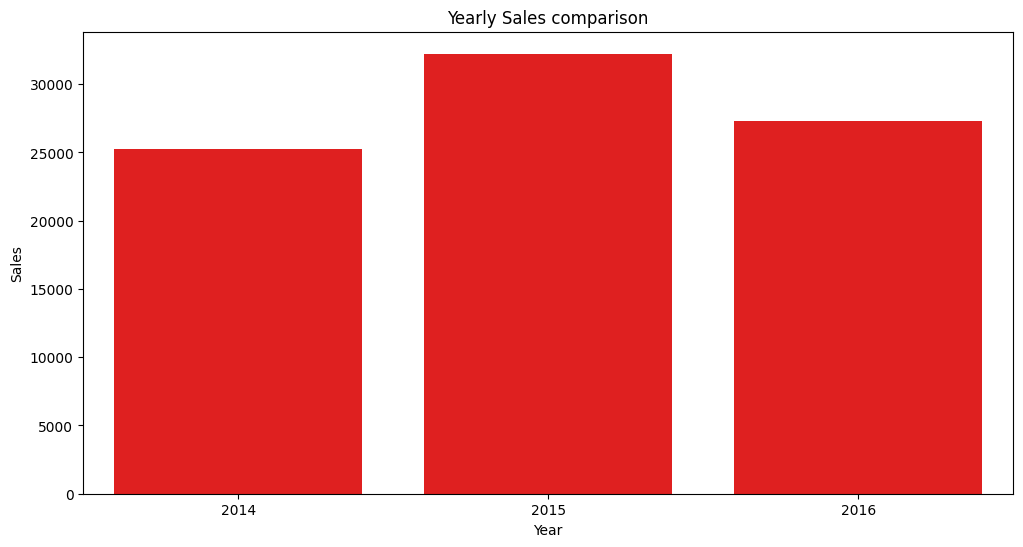

In [31]:
#yearly sales comparison
yearly_sales=feature_and_target.groupby(['year'])['sales'].sum().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(x='year',y='sales',data=yearly_sales, color='r')
plt.title('Yearly Sales comparison')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

**Determining top selling seasons**

In [32]:
#find top-selling items
if 'item' in pjme.columns:
  item_sales=pjme.groupby('item')['sales'].sum().sort_values(ascending=False)
  print('Top selling items:')
  print(item_sales.head(20))



In [33]:
#calculate average sales by season
season_avg_sales=feature_and_target.groupby('season')['sales'].mean().sort_values(ascending=False)
print("\nAverage sales by season:")
print(season_avg_sales)


Average sales by season:
season
Winter    100.322464
Fall       88.091270
Summer     87.247253
Spring     83.245536
Name: sales, dtype: float64


/tmp/ipython-input-414168568.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_avg_sales=feature_and_target.groupby('season')['sales'].mean().sort_values(ascending=False)


In [34]:

import numpy as np

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))

    # Avoid division by zero by replacing 0 with tiny value
    denominator = np.where(denominator == 0, 1e-8, denominator)

    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denominator)



**sales insight card**

In [35]:


print(f'MAE: {mean_absolute_error(pjme_test["sales"],pjme_test_predictions["yhat"]):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(pjme_test["sales"],pjme_test_predictions["yhat"])):.2f}')
print(f'SMAPE: {smape(pjme_test["sales"], pjme_test_predictions["yhat"]):.2f}%')

print('Observation: sales tend to be low during Fall season')
print('Observation: sales tend to be high during Spring season')



MAE: 56.38
RMSE: 73.84
SMAPE: 66.01%
Observation: sales tend to be low during Fall season
Observation: sales tend to be high during Spring season
